In [23]:
import pandas as pd
import numpy as np
import collections
import sys
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn import svm
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import csv
%matplotlib inline

In [2]:
## Read in dataframes 
data_dir = './DataFiles/'
# This file provides a master list of cities that have been locations for games played.
df_cities = pd.read_csv(data_dir + 'Cities.csv')
df_conferences = pd.read_csv(data_dir + 'Conferences.csv')
df_conferencetourney = pd.read_csv(data_dir + 'ConferenceTourneyGames.csv')
df_gamecities = pd.read_csv(data_dir + 'GameCities.csv')
df_tourneycompact = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tourneydetailed = pd.read_csv(data_dir + 'NCAATourneyDetailedResults.csv')
df_tourneyseedroundslots = pd.read_csv(data_dir + 'NCAATourneySeedRoundSlots.csv')
df_tourneyseeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_tourneyslots = pd.read_csv(data_dir + 'NCAATourneySlots.csv')
df_seasoncompact = pd.read_csv(data_dir + 'RegularSeasonCompactResults.csv')
df_seasondetailed = pd.read_csv(data_dir + 'RegularSeasonDetailedResults.csv')
df_seasons = pd.read_csv(data_dir + 'Seasons.csv')
df_secondtourneycompact = pd.read_csv(data_dir + 'SecondaryTourneyCompactResults.csv')
df_coaches = pd.read_csv(data_dir + 'TeamCoaches.csv')
df_teamconferences = pd.read_csv(data_dir + 'TeamConferences.csv')
df_teams = pd.read_csv(data_dir + 'Teams.csv')
# df_teamspellings = pd.read_csv(data_dir + 'TeamSpellings.csv') utf-8 encoding issue

df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [3]:
def handleDifferentCSV(df):
    # The stats CSV is a lit different in terms of naming so below is just some data cleaning
    df['School'] = df['School'].replace('(State)', 'St', regex=True) 
    df['School'] = df['School'].replace('Albany (NY)', 'Albany NY') 
    df['School'] = df['School'].replace('Boston University', 'Boston Univ')
    df['School'] = df['School'].replace('Central Michigan', 'C Michigan')
    df['School'] = df['School'].replace('(Eastern)', 'E', regex=True)
    df['School'] = df['School'].replace('Louisiana St', 'LSU')
    df['School'] = df['School'].replace('North Carolina St', 'NC State')
    df['School'] = df['School'].replace('Southern California', 'USC')
    df['School'] = df['School'].replace('University of California', 'California', regex=True) 
    df['School'] = df['School'].replace('American', 'American Univ')
    df['School'] = df['School'].replace('Arkansas-Little Rock', 'Ark Little Rock')
    df['School'] = df['School'].replace('Arkansas-Pine Bluff', 'Ark Pine Bluff')
    df['School'] = df['School'].replace('Bowling Green St', 'Bowling Green')
    df['School'] = df['School'].replace('Brigham Young', 'BYU')
    df['School'] = df['School'].replace('Cal Poly', 'Cal Poly SLO')
    df['School'] = df['School'].replace('Centenary (LA)', 'Centenary')
    df['School'] = df['School'].replace('Central Connecticut St', 'Central Conn')
    df['School'] = df['School'].replace('Charleston Southern', 'Charleston So')
    df['School'] = df['School'].replace('Coastal Carolina', 'Coastal Car')
    df['School'] = df['School'].replace('College of Charleston', 'Col Charleston')
    df['School'] = df['School'].replace('Cal St Fullerton', 'CS Fullerton')
    df['School'] = df['School'].replace('Cal St Sacramento', 'CS Sacramento')
    df['School'] = df['School'].replace('Cal St Bakersfield', 'CS Bakersfield')
    df['School'] = df['School'].replace('Cal St Northridge', 'CS Northridge')
    df['School'] = df['School'].replace('East Tennessee St', 'ETSU')
    df['School'] = df['School'].replace('Detroit Mercy', 'Detroit')
    df['School'] = df['School'].replace('Fairleigh Dickinson', 'F Dickinson')
    df['School'] = df['School'].replace('Florida Atlantic', 'FL Atlantic')
    df['School'] = df['School'].replace('Florida Gulf Coast', 'FL Gulf Coast')
    df['School'] = df['School'].replace('Florida International', 'Florida Intl')
    df['School'] = df['School'].replace('George Washington', 'G Washington')
    df['School'] = df['School'].replace('Georgia Southern', 'Ga Southern')
    df['School'] = df['School'].replace('Gardner-Webb', 'Gardner Webb')
    df['School'] = df['School'].replace('Illinois-Chicago', 'IL Chicago')
    df['School'] = df['School'].replace('Kent St', 'Kent')
    df['School'] = df['School'].replace('Long Island University', 'Long Island')
    df['School'] = df['School'].replace('Loyola Marymount', 'Loy Marymount')
    df['School'] = df['School'].replace('Loyola (MD)', 'Loyola MD')
    df['School'] = df['School'].replace('Loyola (IL)', 'Loyola-Chicago')
    df['School'] = df['School'].replace('Massachusetts', 'MA Lowell')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    df['School'] = df['School'].replace('Miami (FL)', 'Miami FL')
    df['School'] = df['School'].replace('Miami (OH)', 'Miami OH')
    df['School'] = df['School'].replace('Missouri-Kansas City', 'Missouri KC')
    df['School'] = df['School'].replace('Monmouth', 'Monmouth NJ')
    df['School'] = df['School'].replace('Mississippi Valley St', 'MS Valley St')
    df['School'] = df['School'].replace('Montana St', 'MTSU')
    df['School'] = df['School'].replace('Northern Colorado', 'N Colorado')
    df['School'] = df['School'].replace('North Dakota St', 'N Dakota St')
    df['School'] = df['School'].replace('Northern Illinois', 'N Illinois')
    df['School'] = df['School'].replace('Northern Kentucky', 'N Kentucky')
    df['School'] = df['School'].replace('North Carolina A&T', 'NC A&T')
    df['School'] = df['School'].replace('North Carolina Central', 'NC Central')
    df['School'] = df['School'].replace('Pennsylvania', 'Penn')
    df['School'] = df['School'].replace('South Carolina St', 'S Carolina St')
    df['School'] = df['School'].replace('Southern Illinois', 'S Illinois')
    df['School'] = df['School'].replace('UC-Santa Barbara', 'Santa Barbara')
    df['School'] = df['School'].replace('Southeastern Louisiana', 'SE Louisiana')
    df['School'] = df['School'].replace('Southeast Missouri St', 'SE Missouri St')
    df['School'] = df['School'].replace('Stephen F. Austin', 'SF Austin')
    df['School'] = df['School'].replace('Southern Methodist', 'SMU')
    df['School'] = df['School'].replace('Southern Mississippi', 'Southern Miss')
    df['School'] = df['School'].replace('Southern', 'Southern Univ')
    df['School'] = df['School'].replace('St. Bonaventure', 'St Bonaventure')
    df['School'] = df['School'].replace('St. Francis (NY)', 'St Francis NY')
    df['School'] = df['School'].replace('Saint Francis (PA)', 'St Francis PA')
    df['School'] = df['School'].replace('St. John\'s (NY)', 'St John\'s')
    df['School'] = df['School'].replace('Saint Joseph\'s', 'St Joseph\'s PA')
    df['School'] = df['School'].replace('Saint Louis', 'St Louis')
    df['School'] = df['School'].replace('Saint Mary\'s (CA)', 'St Mary\'s CA')
    df['School'] = df['School'].replace('Mount Saint Mary\'s', 'Mt St Mary\'s')
    df['School'] = df['School'].replace('Saint Peter\'s', 'St Peter\'s')
    df['School'] = df['School'].replace('Texas A&M-Corpus Christian', 'TAM C. Christian')
    df['School'] = df['School'].replace('Texas Christian', 'TCU')
    df['School'] = df['School'].replace('Tennessee-Martin', 'TN Martin')
    df['School'] = df['School'].replace('Texas-Rio Grande Valley', 'UTRGV')
    df['School'] = df['School'].replace('Texas Southern', 'TX Southern')
    df['School'] = df['School'].replace('Alabama-Birmingham', 'UAB')
    df['School'] = df['School'].replace('UC-Davis', 'UC Davis')
    df['School'] = df['School'].replace('UC-Irvine', 'UC Irvine')
    df['School'] = df['School'].replace('UC-Riverside', 'UC Riverside')
    df['School'] = df['School'].replace('Central Florida', 'UCF')
    df['School'] = df['School'].replace('Louisiana-Lafayette', 'ULL')
    df['School'] = df['School'].replace('Louisiana-Monroe', 'ULM')
    df['School'] = df['School'].replace('Maryland-Baltimore County', 'UMBC')
    df['School'] = df['School'].replace('North Carolina-Asheville', 'UNC Asheville')
    df['School'] = df['School'].replace('North Carolina-Greensboro', 'UNC Greensboro')
    df['School'] = df['School'].replace('North Carolina-Wilmington', 'UNC Wilmington')
    df['School'] = df['School'].replace('Nevada-Las Vegas', 'UNLV')
    df['School'] = df['School'].replace('Texas-Arlington', 'UT Arlington')
    df['School'] = df['School'].replace('Texas-San Antonio', 'UT San Antonio')
    df['School'] = df['School'].replace('Texas-El Paso', 'UTEP')
    df['School'] = df['School'].replace('Virginia Commonwealth', 'VA Commonwealth')
    df['School'] = df['School'].replace('Western Carolina', 'W Carolina')
    df['School'] = df['School'].replace('Western Illinois', 'W Illinois')
    df['School'] = df['School'].replace('Western Kentucky', 'WKU')
    df['School'] = df['School'].replace('Western Michigan', 'W Michigan')
    df['School'] = df['School'].replace('Abilene Christian', 'Abilene Chr')
    df['School'] = df['School'].replace('Montana State', 'Montana St')
    df['School'] = df['School'].replace('Central Arkansas', 'Cent Arkansas')
    df['School'] = df['School'].replace('Houston Baptist', 'Houston Bap')
    df['School'] = df['School'].replace('South Dakota St', 'S Dakota St')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    return df

In [4]:
def getTeamName(team_id):
    return df_teams[df_teams['TeamID'] == team_id].values[0][1]
getTeamName(1200)

'Fordham'

In [5]:
df_year = df_seasoncompact[df_seasoncompact['Season'] == 2010]
df_year2 = df_seasondetailed[df_seasondetailed['Season'] == 2010]
#df_year.info()
gamesWon = df_year[df_year.WTeamID == 1120] 
gamesWon2 = df_year2[df_year2.WTeamID == 1120] 
print(gamesWon.head(10))
#print(gamesWon2.head(10))

        Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
108134    2010      11     1120      69     1310      65    H      0
108535    2010      19     1120      80     1237      65    N      0
108770    2010      23     1120      75     1219      54    H      0
109033    2010      29     1120      87     1105      52    N      0
109322    2010      35     1120      68     1438      67    H      0
109795    2010      50     1120      94     1106      78    H      0
109976    2010      57     1120      77     1149      62    H      0
110135    2010      61     1120      95     1204      75    H      0
110991    2010      79     1120      84     1261      80    A      0
111458    2010      89     1120      58     1104      57    H      0


In [6]:
tourneyYear = df_tourneyseeds[df_tourneyseeds['Season'] == 2010]
seed = tourneyYear[tourneyYear['TeamID'] == 1246]
if (len(seed.index) != 0):
    seed = seed.values[0][1]
    tournamentSeed = int(seed[1:3])
    
tournamentSeed

1

In [7]:
def getSeasonData(team_id, year):
    # The data frame below holds stats for every single game in the given year
    df_year = df_seasondetailed[df_seasondetailed['Season'] == year]
    
    df_stats_SOS = pd.read_csv('./RegSeasonStats/MMStats_'+str(year)+'.csv')
    df_stats_SOS = handleDifferentCSV(df_stats_SOS)
    df_ratings = pd.read_csv('./RatingStats/RatingStats_'+str(year)+'.csv')
    df_ratings = handleDifferentCSV(df_ratings)
    
    name = getTeamName(team_id)
    team = df_stats_SOS[df_stats_SOS['School'] == name]
    team_rating = df_ratings[df_ratings['School'] == name]
    
    
    # Finding number of points per game
    gamesWon = df_year[df_year.WTeamID == team_id] 
    totalPoints = gamesWon['WScore'].sum()
    gamesLost = df_year[df_year.LTeamID == team_id] 
    totalGames = gamesWon.append(gamesLost)
    numGames = len(totalGames.index)
    totalPoints += gamesLost['LScore'].sum()
    
    # Finding number of points per game allowed
    totalPointsAllowed = gamesWon['LScore'].sum()
    totalPointsAllowed += gamesLost['WScore'].sum()
    
    #FGM - field goals made
    totalFGM = gamesWon['WFGM'].sum()
    totalFGM += gamesLost['LFGM'].sum()
    
    #FGM - field goals made (by opponent)
    totalOppFGM = gamesWon['LFGM'].sum()
    totalOppFGM += gamesLost['WFGM'].sum()
    
    #FGA - field goals attempted
    totalFGA = gamesWon['WFGA'].sum()
    totalFGA += gamesLost['LFGA'].sum()
    
    #FGA - field goals attempted (by opponent)
    totalOppFGA = gamesWon['LFGA'].sum()
    totalOppFGA += gamesLost['WFGA'].sum()
    
    #FGM3 - three pointers made
    totalFGM3 = gamesWon['WFGM3'].sum()
    totalFGM3 += gamesLost['LFGM3'].sum()
    
    #FGM3 - three pointers made (by opponent)
    totalOppFGM3 = gamesWon['LFGM3'].sum()
    totalOppFGM3 += gamesLost['WFGM3'].sum()
    
    #FGA3 - three pointers attempted
    totalFGA3 = gamesWon['WFGA3'].sum()
    totalFGA3 += gamesLost['LFGA3'].sum()
    
    #FGA3 - three pointers attempted (by opponent)
    totalOppFGA3 = gamesWon['LFGA3'].sum()
    totalOppFGA3 += gamesLost['WFGA3'].sum()
    
    #FTM - free throws made
    totalFTM = gamesWon['WFTM'].sum()
    totalFTM += gamesLost['LFTM'].sum()
    
    #FTM - free throws made (by opponent)
    totalOppFTM = gamesWon['LFTM'].sum()
    totalOppFTM += gamesLost['WFTM'].sum()
    
    #FTA - free throws attempted
    totalFTA = gamesWon['WFTA'].sum()
    totalFTA += gamesLost['LFTA'].sum()
    
    #FTA - free throws attempted (by opponent)
    totalOppFTA = gamesWon['LFTA'].sum()
    totalOppFTA += gamesLost['WFTA'].sum()
    
    #OR - offensive rebounds
    totalOR = gamesWon['WOR'].sum()
    totalOR += gamesLost['LOR'].sum()
    
    #OR - offensive rebounds (by opponent)
    totalOppOR = gamesWon['LOR'].sum()
    totalOppOR += gamesLost['WOR'].sum()
    
    #DR - defensive rebounds
    totalDR = gamesWon['WDR'].sum()
    totalDR += gamesLost['LDR'].sum()
    
    #DR - defensive rebounds (by opponent)
    totalOppDR = gamesWon['LDR'].sum()
    totalOppDR += gamesLost['WDR'].sum()
    
    #Ast - assists
    totalAst = gamesWon['WAst'].sum()
    totalAst += gamesLost['LAst'].sum()
    
    #Ast - assists (by opponent)
    totalOppAst = gamesWon['LAst'].sum()
    totalOppAst += gamesLost['WAst'].sum()
    
    #TO - turnovers committed
    totalTO = gamesWon['WTO'].sum()
    totalTO += gamesLost['LTO'].sum()
    
    #TO - turnovers committed (by opponent)
    totalOppTO = gamesWon['LTO'].sum()
    totalOppTO += gamesLost['WTO'].sum()
    
    #Stl - steals
    totalStl = gamesWon['WStl'].sum()
    totalStl += gamesLost['LStl'].sum()
    
    #Stl - steals (by opponent)
    totalOppStl = gamesWon['LStl'].sum()
    totalOppStl += gamesLost['WStl'].sum()
    
    #Blk - blocks
    totalBlk = gamesWon['WBlk'].sum()
    totalBlk += gamesLost['LBlk'].sum()
    
    #Blk - blocks (by opponent)
    totalOppBlk = gamesWon['LBlk'].sum()
    totalOppBlk += gamesLost['WBlk'].sum()
    
    #PF - personal fouls committed
    totalPF = gamesWon['WPF'].sum()
    totalPF += gamesLost['LPF'].sum()
    
    #PF - personal fouls committed (by opponent)
    totalOppPF = gamesWon['LPF'].sum()
    totalOppPF += gamesLost['WPF'].sum()
    
    #Finding tournament seed for that year
    tourneyYear = df_tourneyseeds[df_tourneyseeds['Season'] == year]
    seed = tourneyYear[tourneyYear['TeamID'] == team_id]
    if (len(seed.index) != 0):
        seed = seed.values[0][1]
        tournamentSeed = int(seed[1:3])
    else:
        tournamentSeed = 25
    
    # Finding number of wins and losses
    numWins = len(gamesWon.index)
    
    # Creating averages
    if numGames == 0 or len(team_rating.index) == 0:
        avgPoints = 0
        avgPointsAllowed = 0    
        avgFGM = 0
        avgOppFGM = 0
        avgFGA = 0
        avgOppFGA = 0
        avgFGM3 = 0
        avgOppFGM3 = 0
        avgFGA3 = 0
        avgOppFGA3 = 0
        avgFTM = 0
        avgOppFTM = 0
        avgFTA = 0
        avgOppFTA = 0
        avgOR = 0
        avgOppOR = 0
        avgDR = 0
        avgOppDR = 0
        avgAst = 0
        avgOppAst = 0
        avgTO = 0
        avgOppTO = 0
        avgStl = 0
        avgOppStl = 0
        avgBlk = 0
        avgOppBlk = 0
        avgPF = 0
        avgOppPF = 0
        tournamentSeed = 0
        sos = 0
        srs = 0
    else:
        avgPoints = totalPoints/numGames
        avgPointsAllowed = totalPointsAllowed/numGames
        avgFGM = totalFGM/numGames
        avgOppFGM = totalOppFGM/numGames
        avgFGA = totalFGA/numGames
        avgOppFGA = totalOppFGA/numGames
        avgFGM3 = totalFGM3/numGames
        avgOppFGM3 = totalOppFGM3/numGames
        avgFGA3 = totalFGA3/numGames
        avgOppFGA3 = totalOppFGA3/numGames
        avgFTM = totalFTM/numGames
        avgOppFTM = totalOppFTM/numGames
        avgFTA = totalFTA/numGames
        avgOppFTA = totalOppFTA/numGames
        avgOR = totalOR/numGames
        avgOppOR = totalOppOR/numGames
        avgDR = totalDR/numGames
        avgOppDR = totalOppDR/numGames
        avgAst = totalAst/numGames
        avgOppAst = totalOppAst/numGames
        avgTO = totalTO/numGames
        avgOppTO = totalOppTO/numGames
        avgStl = totalStl/numGames
        avgOppStl = totalOppStl/numGames
        avgBlk = totalBlk/numGames
        avgOppBlk = totalOppBlk/numGames
        avgPF = totalPF/numGames
        avgOppPF = totalOppPF/numGames
        sos = team['SOS'].values[0]
        srs = team['SRS'].values[0]
    

    #return gamesLost
    return [numWins, avgPoints, avgPointsAllowed, avgFGM, avgOppFGM, avgFGA, avgOppFGA, avgFGM3, avgOppFGM3, avgFGA3, avgOppFGA3,
            avgFTM, avgOppFTM, avgFTA, avgOppFTA, avgOR, avgOppOR, avgDR, avgOppDR, avgAst, avgOppAst, avgTO, avgOppTO, avgStl,
            avgOppStl, avgBlk, avgOppBlk, avgPF, avgOppPF, tournamentSeed, sos, srs]
    
    #return [numWins]

In [8]:
#getSeasonData(1246, 2010) #Kentucky

In [9]:
#getSeasonData(1242, 2016) #Kansas

In [10]:
def compareTwoTeams(id_1, id_2, year):
    team_1 = getSeasonData(id_1, year)
    team_2 = getSeasonData(id_2, year)
    diff = [a - b for a, b in zip(team_1, team_2)]
    return diff

In [11]:
#compareTwoTeams(1246,1452, 2010)

In [12]:
teamList = df_teams['TeamName'].tolist()

def createSeasonDict(year):
    seasonDictionary = collections.defaultdict(list)
    for team in teamList:
        team_id = df_teams[df_teams['TeamName'] == team].values[0][0]
        team_vector = getSeasonData(team_id, year)
        seasonDictionary[team_id] = team_vector
    return seasonDictionary


In [13]:
def getHomeStat(row):
    if (row == 'H'):
        home = 1
    if (row == 'A'):
        home = -1
    if (row == 'N'):
        home = 0
    return home

In [14]:
def createTrainingSet(years):
    totalNumGames = 0
    for year in years:
        season = df_seasoncompact[df_seasoncompact['Season'] == year]
        totalNumGames += len(season.index)
        tourney = df_tourneycompact[df_tourneycompact['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(getSeasonData(1246,2010))
    #xTrain = np.zeros((totalNumGames, numFeatures + 1))
    #yTrain = np.zeros((totalNumGames))
    xTrain=[]
    yTrain=[]
    indexCounter = 0
    for year in years:
        team_vectors = createSeasonDict(year)
        season = df_seasoncompact[df_seasoncompact['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = df_tourneycompact[df_tourneycompact['Season'] == year]
        numGamesInSeason += len(tourney.index)
        #xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
        #yTrainSeason = np.zeros(( numGamesInSeason ))
        xTrainSeason = []
        yTrainSeason = []
        counter = 0
        for index, row in season.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            #if w_vector is np.any(w_vector): #check if w_vector contains only zeros
            #    continue
            if all([x == 0 for x in w_vector]):
                continue
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = getHomeStat(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home) 
                #xTrainSeason[counter] = diff
                #yTrainSeason[counter] = 1
                xTrainSeason.append(diff)
                yTrainSeason.append(1)
            else:
                diff.append(-home)
                #xTrainSeason[counter] = [ -p for p in diff]
                #yTrainSeason[counter] = 0
                xTrainSeason.append([-p for p in diff])
                yTrainSeason.append(0)
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            #if w_vector is np.any(w_vector): #check if w_vector contains only zeros
            #    continue
            if all([x == 0 for x in w_vector]):
                continue
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0 #All tournament games are neutral
            if (counter % 2 == 0):
                diff.append(home) 
                #xTrainSeason[counter] = diff
                #yTrainSeason[counter] = 1
                xTrainSeason.append(diff)
                yTrainSeason.append(1)
            else:
                diff.append(-home)
                #xTrainSeason[counter] = [ -p for p in diff]
                #yTrainSeason[counter] = 0
                xTrainSeason.append([-p for p in diff])
                yTrainSeason.append(0)
            counter += 1
        xTrain[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        yTrain[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
    #xTrain[(xTrain != 0).sum(axis=1) >= 5, :]
    #xTrain[:,:29][~np.all(xTrain == 0, axis=1)]
    xTrain = np.array(xTrain)
    yTrain = np.array(yTrain)
    return xTrain, yTrain

## Testing

In [15]:
numFeatures = len(getSeasonData(1246,2010))
print(numFeatures)
team_vectors = createSeasonDict(2016)
season = df_seasoncompact[df_seasoncompact['Season'] == 2016]
numGamesInSeason = len(season.index)
tourney = df_tourneycompact[df_tourneycompact['Season'] == 2016]
numGamesInSeason += len(tourney.index)
xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
yTrainSeason = np.zeros(( numGamesInSeason ))
counter = 0
for index, row in season.iterrows():
    w_team = row['WTeamID']
    w_vector = team_vectors[w_team]
    l_team = row['LTeamID']
    l_vector = team_vectors[l_team]
    diff = [a - b for a, b in zip(w_vector, l_vector)]
    home = getHomeStat(row['WLoc'])
    if (counter % 2 == 0):
        diff.append(home) 
        xTrainSeason[counter] = diff
        yTrainSeason[counter] = 1
    else:
        diff.append(-home)
        xTrainSeason[counter] = [-p for p in diff]
        yTrainSeason[counter] = 0
    counter += 1

#np.savetxt("xTrainSeason2016.csv", xTrainSeason, delimiter=",")
print(season.iloc[2,:])
print(team_vectors[1112])
print(team_vectors[1334])
diff = [a - b for a, b in zip(team_vectors[1112], team_vectors[1334])]
print(diff)
print(xTrainSeason[2])

32
Season     2016
DayNum       11
WTeamID    1112
WScore       79
LTeamID    1334
LScore       61
WLoc          H
NumOT         0
Name: 139922, dtype: object
[25, 81.21212121212122, 69.0, 28.060606060606062, 25.12121212121212, 58.24242424242424, 60.81818181818182, 6.515151515151516, 6.090909090909091, 17.03030303030303, 18.96969696969697, 18.575757575757574, 12.666666666666666, 25.696969696969695, 17.78787878787879, 11.636363636363637, 9.484848484848484, 28.606060606060606, 21.545454545454547, 14.515151515151516, 12.212121212121213, 12.818181818181818, 11.606060606060606, 4.909090909090909, 5.393939393939394, 4.787878787878788, 3.4545454545454546, 18.21212121212121, 22.0, 6, 7.23, 18.79]
[6, 68.5, 74.42307692307692, 23.807692307692307, 23.923076923076923, 55.34615384615385, 55.19230769230769, 6.576923076923077, 7.423076923076923, 20.423076923076923, 20.26923076923077, 14.307692307692308, 19.153846153846153, 21.26923076923077, 27.192307692307693, 10.038461538461538, 10.461538461538462,

In [16]:
years = range(2010,2013)
xTrain, yTrain = createTrainingSet(years)
#np.save('xTrain', xTrain)
#np.save('yTrain', yTrain)
print(xTrain)

[[ -5.           1.87594697   7.36268939 ...  12.15         8.6
    1.        ]
 [-10.          -7.83266129   4.6875     ... -12.57       -22.95
    1.        ]
 [ 25.          13.59013283 -20.79411765 ...  16.37        49.85
    1.        ]
 ...
 [  0.          -0.26559715  -2.88057041 ...  -0.86         2.23
    0.        ]
 [  6.           7.84789916  -2.17142857 ...  -1.09         8.54
    0.        ]
 [ -5.          -1.64616756   2.93939394 ...   2.          -3.01
    0.        ]]


In [17]:
xTrain.shape, yTrain.shape
xTrain
#np.savetxt("xTrain.csv", xTrain, delimiter=",")
#np.savetxt("yTrain.csv", yTrain, delimiter=",")

array([[ -5.        ,   1.87594697,   7.36268939, ...,  12.15      ,
          8.6       ,   1.        ],
       [-10.        ,  -7.83266129,   4.6875    , ..., -12.57      ,
        -22.95      ,   1.        ],
       [ 25.        ,  13.59013283, -20.79411765, ...,  16.37      ,
         49.85      ,   1.        ],
       ...,
       [  0.        ,  -0.26559715,  -2.88057041, ...,  -0.86      ,
          2.23      ,   0.        ],
       [  6.        ,   7.84789916,  -2.17142857, ...,  -1.09      ,
          8.54      ,   0.        ],
       [ -5.        ,  -1.64616756,   2.93939394, ...,   2.        ,
         -3.01      ,   0.        ]])

In [18]:
#xTrain.shape

(15960, 33)

In [19]:
#x = createSeasonDict(2016)

In [20]:
#x[1109] - zeros
#1101 - not zeros
#print(x)
#all([y == 0 for y in x[1109]])

True

## Loading Data

In [30]:
years = range(2014,2018)
xTrain, yTrain = createTrainingSet(years)
#np.save('xTrain', xTrain)
#np.save('yTrain', yTrain)
#xTrain = np.load('PrecomputedMatrices/xTrain.npy')
#yTrain = np.load('PrecomputedMatrices/yTrain.npy')

In [31]:
xTrain.shape, yTrain.shape

((21748, 33), (21748,))

## Prelim Model Work

In [18]:
model4 = RandomForestClassifier(n_estimators=200)
model2 = linear_model.BayesianRidge()
model5 = AdaBoostClassifier(n_estimators=100)
model = GradientBoostingRegressor(n_estimators=100)
model3 = KNeighborsClassifier(n_neighbors=101)

In [19]:
def showFeatureImportance(my_categories):
    fx_imp = pd.Series(model.feature_importances_, index=my_categories)
    fx_imp /= fx_imp.max()
    fx_imp.sort()
    fx_imp.plot(kind='barh')

In [20]:
def showDependency(predictions, test, stat, my_categories):
    difference = test[:,my_categories.index(stat)]
    plt.scatter(difference, predictions)
    plt.ylabel('Probability of Team 1 Win')
    plt.xlabel(stat + ' Difference (Team 1 - Team 2)')
    plt.show()

In [22]:
#categories=['Wins','PPG','PPGA','PowerConf','3PG', 'APG','TOP','Conference Champ','Tourney Conference Champ',
#           'Seed','SOS','SRS', 'RPG', 'SPG', 'Tourney Appearances','National Championships','Location']
categories = ['numWins', 'avgPoints', 'avgPointsAllowed', 'avgFGM', 'avgOppFGM', 'avgFGA', 'avgOppFGA', 'avgFGM3', 'avgOppFGM3', 'avgFGA3', 'avgOppFGA3',
            'avgFTM', 'avgOppFTM', 'avgFTA', 'avgOppFTA', 'avgOR', 'avgOppOR', 'avgDR', 'avgOppDR', 'avgAst', 'avgOppAst', 'avgTO', 'avgOppTO', 'avgStl',
            'avgOppStl', 'avgBlk', 'avgOppBlk', 'avgPF', 'avgOppPF', 'tournamentSeed', 'sos', 'srs', 'location']
accuracy=[]
totals=[]
for i in range(1):
    X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)
    results1 = model.fit(X_train, Y_train)
    preds1 = model.predict(X_test)
    
    results2 = model2.fit(X_train, Y_train)
    preds2 = model2.predict(X_test)
    
    results3 = model3.fit(X_train, Y_train)
    preds3 = model3.predict(X_test)

    results4 = model4.fit(X_train, Y_train)
    preds4 = model4.predict(X_test)
    
    results5 = model5.fit(X_train, Y_train)
    preds5 = model5.predict(X_test)
    
    preds = (preds1 + preds2 + preds3 + preds4 + preds5)/5
    totals.append(preds)
    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    accuracy.append(np.mean(preds == Y_test))
    #accuracy.append(np.mean(predictions == Y_test))
print("The accuracy is: ", sum(accuracy)/len(accuracy))


The accuracy is:  0.7586189126513785


/home/aksan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


/home/aksan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


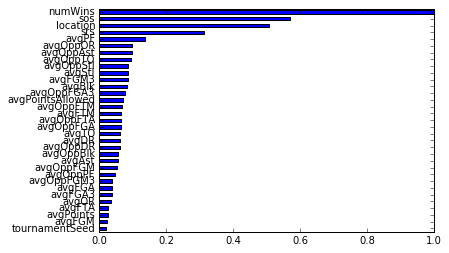

In [24]:
showFeatureImportance(categories)

## Actual Model

In [72]:
#model = tree.DecisionTreeClassifier()
#model = tree.DecisionTreeRegressor()
#model = linear_model.LogisticRegression()
#model = linear_model.BayesianRidge()
#model = linear_model.Lasso()
model = svm.SVC()
#model = svm.SVR()
#model = linear_model.Ridge(alpha = 0.5)
#model = AdaBoostClassifier(n_estimators=100)
#model = GradientBoostingClassifier(n_estimators=100)
#model = GradientBoostingRegressor(n_estimators=100, max_depth=5)
#model = RandomForestClassifier(n_estimators=64)
#model = KNeighborsClassifier(n_neighbors=39)
#neuralNetwork(10)
#model = VotingClassifier(estimators=[('GBR', model1), ('BR', model2), ('KNN', model3)], voting='soft')
#model = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=0.1)

In [42]:
from sklearn.utils.testing import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

/home/aksan/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/aksan/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/aksan/anaconda3/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
DPGMM
DecisionTreeClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GMM
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultinomialNB
NuSVC
QuadraticDiscriminantAnalysis
RandomForestClassifier
SGDClassifier
SVC
VBGMM
_BinaryGaussianProcessClassifierLaplace
_ConstantPredictor
_DPGMMBase
_GMMBase


In [43]:
accuracy=[]
for i in range(1):
    X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)
    results = model.fit(X_train, Y_train)
    preds = model.predict(X_test)

    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    accuracy.append(np.mean(preds == Y_test))
    #accuracy.append(np.mean(predictions == Y_test))
    print("Finished iteration:", i)
print("The accuracy is", sum(accuracy)/len(accuracy))

Finished iteration: 0
The accuracy is 0.7632885782600699


In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)

logreg = linear_model.LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4869, with best C: 0.01


In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)

ada = AdaBoostClassifier()
params = {'n_estimators': np.arange(10,150,10)}
clf2 = GridSearchCV(ada, params, scoring='neg_log_loss', refit=True)
clf2.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best num_estimators: {}'.format(clf2.best_score_, clf2.best_params_['n_estimators']))

Best log_loss: -0.6426, with best C: 10


In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)

gb = GradientBoostingClassifier()
params = {'n_estimators': np.arange(10,150,10), 'max_depth': np.arange(1,5,1)}
clf3 = GridSearchCV(gb, params, scoring='neg_log_loss', refit=True)
clf3.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best num_estimators: {} and best max_depth: {}'.format(clf3.best_score_, clf3.best_params_['n_estimators']), clf3.best_params_['max_depth'])


IndexError: tuple index out of range

In [57]:
clf3.best_params_['n_estimators']

70

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(xTrain, yTrain)

knn = KNeighborsClassifier()
params = {'n_neighbors': np.arange(1,50,1)}
clf4 = GridSearchCV(knn, params, scoring='neg_log_loss', refit=True)
clf4.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best num_estimators: {}'.format(clf4.best_score_, clf4.best_params_['n_neighbors']))


Best log_loss: -0.5068, with best num_estimators: 49


# Applying Model

In [33]:
def predictGame(team_1_vector, team_2_vector, home):
    diff = [a - b for a, b in zip(team_1_vector, team_2_vector)]
    diff.append(home)
    #return model.predict([diff]) 
    return clf.predict_proba([diff])

In [34]:
# This was the national championship matchup last year
team1_name = 'North Carolina' #1314
team2_name = 'Villanova' #1437
team1_vector = getSeasonData(df_teams[df_teams['TeamName'] == team1_name].values[0][0], 2016)
team2_vector = getSeasonData(df_teams[df_teams['TeamName'] == team2_name].values[0][0], 2016)
print('Probability that ' + team1_name + ' wins:', predictGame(team1_vector, team2_vector, 0))
#team1_vector
#team2_vector
diff = [a - b for a, b in zip(team1_vector, team2_vector)]
diff
diff.append(0)
clf.predict_proba([diff])

Probability that North Carolina wins: [[0.49724076 0.50275924]]


array([[0.49724076, 0.50275924]])

In [37]:
sample_sub_pd = pd.read_csv('SampleSubmissionStage1.csv')
def createPrediction():
    results = [[0 for x in range(2)] for x in range(len(sample_sub_pd.index))]
    for index, row in sample_sub_pd.iterrows():
        matchup_id = row['ID']
        year = matchup_id[0:4]
        team1_id = matchup_id[5:9]
        team2_id = matchup_id[10:14]
        team1_vector = getSeasonData(int(team1_id), int(year))
        team2_vector = getSeasonData(int(team2_id), int(year))
        pred = predictGame(team1_vector, team2_vector, 0)
        results[index][0] = matchup_id
        results[index][1] = np.clip(pred[0,1], 0.05, 0.95)
        #results[index][1] = pred[0][1]
    results = pd.np.array(results)
    firstRow = [[0 for x in range(2)] for x in range(1)]
    firstRow[0][0] = 'id'
    firstRow[0][1] = 'pred'
    with open("result8.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(firstRow)
        writer.writerows(results)

In [38]:
createPrediction()

In [121]:
def getAllTeamVectors():
    year = 2016
    numFeatures = len(getSeasonData(1181,2012))
    numTeams = len(df_teams)
    teamvecs = np.zeros(( numTeams, numFeatures ))
    teams=[]
    counter = 0
    for team in teamList:
        team_id = df_teams[df_teams['TeamName'] == team].values[0][0]
        team_vector = getSeasonData(team_id, year)
        if (team_vector[0] == 0 or team_vector[4] == 0):
            continue
        teamvecs[counter] = team_vector
        teams.append(team)
        counter += 1
    team = pd.np.array(teams)
    team = np.reshape(team, (team.shape[0], 1))
    
    with open("allNames.csv", "w") as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerows(team)
    with open("allVecs.csv", "w") as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerows(teamvecs)
    with open("combine.csv", "w") as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerows([team,teamvecs])
getAllTeamVectors()